Christopher Orcilla
Midterm: MongoDB Notebooks

What I wanted to find out in this analysis really is if pumping up a movie's budget actually made a good movie (at least liked by a general audience).
I'm assuming money solves all your problems and would most definately be the reason for a higher rating.

In [1]:
# This code block is used to import my JSON file holding secret username and password data.
# It will also use my secret info to connect to the MongoDB server.

import json
from pymongo import MongoClient

# Load secrets from JSON file
with open(r"C:\Users\orcil\Desktop\Data320\credentials.json") as f:
    credentials = json.load(f)

# Extract credentials
username = credentials["MONGO_USERNAME"]
password = credentials["MONGO_PASSWORD"]
cluster = credentials["MONGO_CLUSTER"]
database = credentials["MONGO_DATABASE"]

# Debug check
print("Username:", username)

# Build MongoDB URI
uri = f"mongodb+srv://{username}:{password}@{cluster}/{database}?retryWrites=true&w=majority"

# Connect to MongoDB
client = MongoClient(uri)
db = client[database]

# Test connection
print("Collections:", db.list_collection_names())

Username: orcillac
Collections: ['IMDB', 'Metacritic', 'IMDB_FIXED']


In [2]:
# Defines the Pipeline used for the IMDB collection

imdb_pipeline = [
    {
        "$project": {
            "mpaa_rating": {
                "$first": {
                    "$setIntersection": [
                        { "$split": ["$certification", ", "] },
                        ["G", "PG", "PG_13", "R", "NC-17"]
                    ]
                }
            },
            "release_date": "$release_date",
            "user_rating" : "$user_rating",
            "cast" : "$cast",
            "company" : "$company",
            "director" : "$director",
            "genres" : "$genres",
            "producer" : "$producer",
            "title" : "$title",
            "votes" : "$votes",
            "runtime" : "$runtime",
            "opening_check_usd": {
                "$regexMatch": {
                    "input": "$opening_weekend",
                    "regex": r"^\$"
                }
            },
            "opening_value": {
                "$regexFind": {
                    "input": "$opening_weekend",
                    "regex": r"\$([\d,]+)"
                }
            },
            "sales_check_usd": {
                "$regexMatch": {
                    "input": "$gross_sales",
                    "regex": r"^\$"
                }
            },
            "sales_value": {
                "$regexFind": {
                    "input": "$gross_sales",
                    "regex": r"([\d,]+)"
                }
            },
            "budget_check_usd": {
                "$regexMatch": {
                    "input": "$budget",
                    "regex": r"^\$"
                }
            },
            "budget_value": {
                "$regexFind": {
                    "input": "$budget",
                    "regex": r"([\d,]+)"
                }
            }
        }
    },
    {
        "$addFields": {
            "release_month": { "$month": "$release_date" },
            "release_day": { "$dayOfMonth": "$release_date" },
            "release_year": { "$year": "$release_date" },
    
            "opening_usd": {
                "$switch": {
                    "branches": [
                        {
                            "case": "$opening_check_usd",
                            "then": {
                                "$toLong": {
                                    "$replaceAll": {
                                        "input": {
                                            "$replaceAll": {
                                                "input": "$opening_value.match",
                                                "find": { "$literal": "$" },
                                                "replacement": ""
                                            }
                                        },
                                        "find": ",",
                                        "replacement": ""
                                    }
                                }
                            }
                        }
                    ],
                    "default": None
                }
            },

            "sales_usd": {
                "$switch": {
                    "branches": [
                        {
                            "case": "$sales_check_usd",
                            "then": {
                                "$toLong": {
                                    "$replaceAll": {
                                        "input": "$sales_value.match",
                                        "find": ",",
                                        "replacement": ""
                                    }
                                }
                            }
                        }
                    ],
                    "default": None
                }
            },

            "usdBudget": {
                "$switch": {
                    "branches": [
                        {
                            "case": "$budget_check_usd",
                            "then": {
                                "$toLong": {
                                    "$replaceAll": {
                                        "input": "$budget_value.match",
                                        "find": ",",
                                        "replacement": ""
                                    }
                                }
                            }
                        }
                    ],
                    "default": None
                }
            }
        }
    }
]



In [3]:
# Imports the IMDB data using the pipeline. Also tests if the pipeline worked correctly.
import pandas as pd
import datetime


# Filters for 2002 only
start_date = datetime.datetime(2002, 1, 1)
end_date = datetime.datetime(2003, 1, 1)

# Appends the pipeline to add a filter for movies released in 2002
imdb_filter = [
    {
        "$match": {
            "release_date": {
                "$gte": start_date,
                "$lt": end_date
            }
        }
    }
] + imdb_pipeline

imdb_collection = db["IMDB_FIXED"]
imdb_data = list(imdb_collection.aggregate(imdb_filter))
imdb_data_frame = pd.DataFrame(imdb_data)
imdb_data_frame.head()

,_id,mpaa_rating,release_date,user_rating,cast,company,director,genres,producer,title,...,sales_check_usd,sales_value,budget_check_usd,budget_value,release_month,release_day,release_year,opening_usd,sales_usd,usdBudget
0,636ac9d6d62a76b6b8c6737f,None,2002-02-26,5.2,"Jason Lee, Renée Humphrey, Jason Mewes, Carmen...","Aaron Gustafson, IndieDVD, Kelly McCarthy, Vie...","Matthew Gissing, Malcolm Ingram",Comedy,"Lisa N. Cohen, Mark Cohen, Matthew Gissing, Ma...",Drawing Flies,...,False,None,False,None,2,26,2002,NaN,NaN,NaN
1,636b07743bc31743d94b4de5,PG,2002-06-08,5.2,"Freddie Prinze Jr., Sarah Michelle Gellar, Mat...","Warner Bros., Mosaic, Atlas Entertainment",Raja Gosnell,"Adventure, Comedy, Family, Fantasy, Mystery","Joseph Barbera, Sheryl Benko, Robert Engelman,...",Scooby-Doo,...,True,"{'match': '99,000,000,', 'idx': 1, 'captures':...",True,"{'match': '84,000,000', 'idx': 1, 'captures': ...",6,8,2002,54155312.0,99000000.0,84000000.0
2,636b07773bc31743d94b4de6,R,2002-11-01,7.5,"Alex Palmer, Bindu De Stoppani, Jukka Hiltunen...","DNA Films, British Film Council",Danny Boyle,"Drama, Horror, Sci-Fi, Thriller","Robert How, Andrew Macdonald",28 Days Later...,...,True,"{'match': '37,654,970', 'idx': 1, 'captures': ...",False,"{'match': '8,000,000', 'idx': 3, 'captures': [...",11,1,2002,NaN,37654970.0,NaN
3,636b077a3bc31743d94b4de7,NaN,2002-10-02,7.1,"Naomi Watts, Martin Henderson, David Dorfman, ...","Dreamworks Pictures, Parkes/MacDonald Image Na...",Gore Verbinski,"Horror, Mystery","Benita Allen, Neal Edelstein, Christine Iso, R...",The Ring,...,True,"{'match': '249,348,933', 'idx': 1, 'captures':...",True,"{'match': '48,000,000', 'idx': 1, 'captures': ...",10,2,2002,15015393.0,249348933.0,48000000.0
4,636b077d3bc31743d94b4de8,PG,2002-11-03,7.4,"Daniel Radcliffe, Rupert Grint, Emma Watson, R...","Warner Bros., Heyday Films, 1492 Pictures, MIR...",Chris Columbus,"Adventure, Family, Fantasy, Mystery","Michael Barnathan, David Barron, Chris Columbu...",Harry Potter and the Chamber of Secrets,...,True,"{'match': '878,979,634,', 'idx': 1, 'captures'...",True,"{'match': '100,000,000', 'idx': 1, 'captures':...",11,3,2002,NaN,878979634.0,100000000.0


In [4]:
# Imports Metacritic Data

mc_collection = db["Metacritic"]
mc_data = pd.DataFrame(list(db["Metacritic"].find()))

# Convert string to datetime
mc_data["release_date"] = pd.to_datetime(mc_data["release_date"], errors="coerce")

# Filter by year 2002
mc_data = mc_data[
    (mc_data["release_date"] >= datetime.datetime(2002, 1, 1)) &
    (mc_data["release_date"] < datetime.datetime(2003, 1, 1))
]

mc_data.head()

,_id,movie_id,title,release_date,description,score,thumbnail
749,6821211a25dd84f3a65f0fd4,11983,Spirited Away,2002-09-20,"A young girl, Chihiro, becomes trapped in a st...",96,https://static.metacritic.com/images/products/...
750,6821211a25dd84f3a65f0fd5,11984,Atanarjuat: The Fast Runner,2002-06-07,Evil in the form of an unknown shaman divides ...,91,https://static.metacritic.com/images/products/...
751,6821211a25dd84f3a65f0fd6,11985,Bloody Sunday,2002-10-04,This controversial and critically acclaimed fi...,90,https://static.metacritic.com/images/products/...
752,6821211a25dd84f3a65f0fd7,11986,Y Tu Mamá También,2002-03-15,"Abandoned by their girlfriends for the summer,...",88,https://static.metacritic.com/images/products/...
753,6821211a25dd84f3a65f0fd8,11987,Time Out,2002-03-29,"After losing his job, Vincent (Recoing) can't ...",88,https://static.metacritic.com/images/products/...


In [ ]:
# Merge the two data sets, I used exactly what was in the assignment page.

combined_data = pd.merge(imdb_data_frame, mc_data, how="inner", on="title")

In [53]:
# Regression analysis

import statsmodels.formula.api as smf

regression_model = smf.ols('user_rating ~ sales_usd + usdBudget + score + runtime', data = combined_data).fit()
print(regression_model.summary())

                            OLS Regression Results                            
Dep. Variable:            user_rating   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     38.18
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           8.46e-19
Time:                        02:27:14   Log-Likelihood:                -88.235
No. Observations:                  97   AIC:                             186.5
Df Residuals:                      92   BIC:                             199.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.1294      0.403      7.769      0.0

You can already see based on the P-value that Budget may not be the best indicator

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# AI sentiment analysis code
# I couldn't get the original AI to work "cardiffnlp/twitter-xlm-roberta-base-sentiment" so I found one that is pretty much the same
# The only difference is that it uses Label_0, Label_1, and Label_2 instead of negative, neutral, and positive respectively
# Besides this, the code is pretty much from the lecture slides

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

sentiment_task = pipeline("sentiment-analysis", model= model, tokenizer = tokenizer)


# Checks if output works
print(sentiment_task("This movie was amazing!"))
print(sentiment_task("This movie sucks!"))
print(sentiment_task("Gravity is one of the laws of physics."))

c:\Users\orcil\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\orcil\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\orcil\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to

[{'label': 'LABEL_2', 'score': 0.990454375743866}]
[{'label': 'LABEL_0', 'score': 0.9816377758979797}]
[{'label': 'LABEL_1', 'score': 0.795283317565918}]


In [ ]:
# Sentiment Function
# This will makes negative reviews be from -1.5 to -0.5. Neutral from -0.5 to 0.5. Positive from 0.5 to 1.5
# This is a direct cut from the lecture slides

def calculate_sentiment(text):
    if text is None:
        return 0
    sentiment = sentiment_task(text)
    if sentiment[0]['label'] == 'LABEL_0':
        return 0 - sentiment[0]['score'] - 0.5
    elif sentiment[0]['label'] == 'LABEL_1':
        return sentiment[0]['score'] - 0.5
    elif sentiment[0]['label'] == 'LABEL_2':
        return 1 + sentiment[0]['score'] - 0.5


# Output Test
print(calculate_sentiment("This movie was amazing!"))
print(calculate_sentiment("This movie sucks!"))
print(calculate_sentiment("Gravity is one of the laws of physics."))
print(calculate_sentiment(None))

1.490454375743866
-1.4816377758979797
0.29528331756591797
0


In [ ]:
# Creates a cew column in the table for sentiment
# This is a direct cut from the lecture slides

sentiment_column = combined_data.apply(lambda row : calculate_sentiment(row.get('description')), axis = 1)

combined_data["sentiment"] = sentiment_column

combined_data.head

<bound method NDFrame.head of                         _id_x mpaa_rating release_date_x  user_rating  \
0    636b07743bc31743d94b4de5          PG     2002-06-08          5.2   
1    636b077a3bc31743d94b4de7         NaN     2002-10-02          7.1   
2    636b077d3bc31743d94b4de8          PG     2002-11-03          7.4   
3    636b077f3bc31743d94b4de9           R     2002-07-01          3.9   
4    636b07833bc31743d94b4dea         NaN     2002-04-30          7.4   
..                        ...         ...            ...          ...   
198  636b0ce53bc31743d94b500f           R     2002-08-02          5.4   
199  636b0ce83bc31743d94b5010           R     2002-05-09          6.5   
200  636b0ced3bc31743d94b5012         NaN     2002-01-01          5.6   
201  636b0d3a3bc31743d94b5031           R     2002-02-20          6.1   
202  636b0dbc3bc31743d94b5067         NaN     2002-06-14          7.6   

                                                  cast  \
0    Freddie Prinze Jr., Sarah Mich

Chart 1: IMDB vs. Metascore

For the first chart, I wanted to see the differences between IMDB and Metascore.
This was mainly to see which scoring seemed more "objective."
Depending on the answer, I will use that scoring system for the next chart.

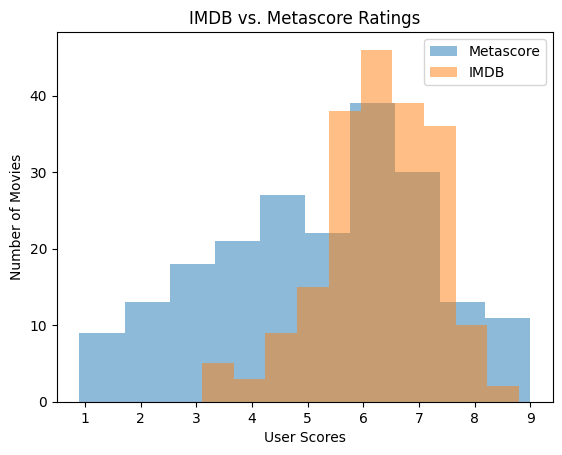

In [ ]:
# Histogram for IMDB vs. Metascore

import matplotlib.pyplot as plt

ratings_data = combined_data[["user_rating","score"]].dropna()


plt.title("IMDB vs. Metascore Ratings")
plt.xlabel("User Scores")
plt.ylabel("Number of Movies")
plt.hist(ratings_data["score"] / 10, alpha=0.5, label="Metascore") # Divides metascore by 10 so the range is the same as IMDB ratings
plt.hist(ratings_data["user_rating"], alpha=0.5, label="IMDB")
plt.legend(loc='upper right')
plt.show()

Chart 2: Metascore vs. Film Budget Colored by Sentiment

Based on Chart 1, I decided that Metascore seemed more objective as they actually used the whole scoring range.
Using this, I can now see if a movie's budget actually affects how good it is.
Also, I decided to add a little spice to the graph by having it colored based on the movie's sentiment.
Might as well get some more data in there.

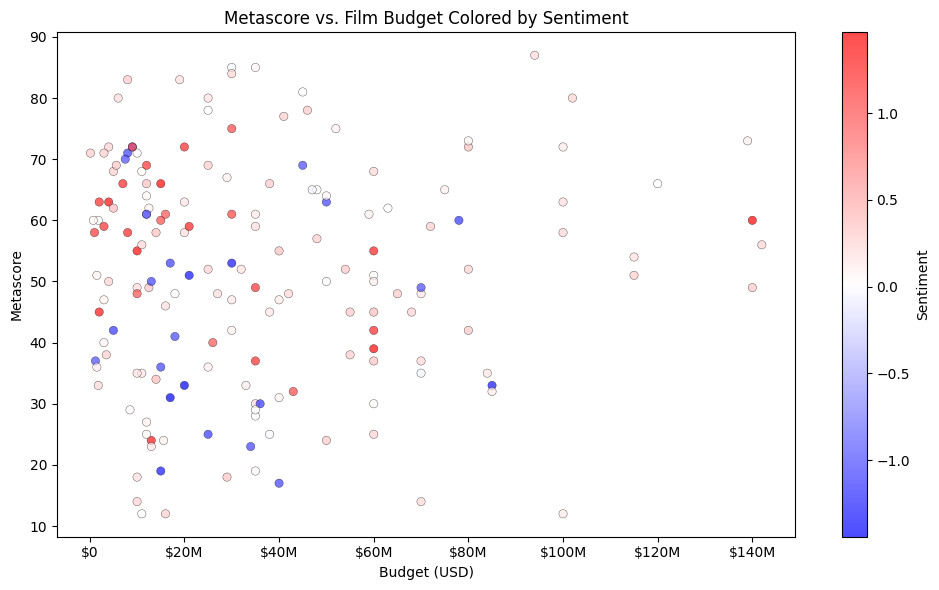

In [ ]:
# This chart I got help from ChatGPT to get the USD formatting.
# Scatter plot for Metascore vs. Film Budget colored by Sentiment

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

plot_data = combined_data.dropna(subset=["score", "usdBudget", "sentiment"])

# Formatter function for currency in millions
def millions_formatter(x, pos):
    if x >= 1_000_000_000:
        return f'${x/1_000_000_000:.1f}B'
    elif x >= 1_000_000:
        return f'${x/1_000_000:.0f}M'
    elif x >= 1_000:
        return f'${x/1_000:.0f}K'
    else:
        return f'${x:.0f}'

plt.figure(figsize=(10, 6))

# Scatter plot
scatter = plt.scatter(
    plot_data["usdBudget"],
    plot_data["score"],
    c=plot_data["sentiment"],
    cmap="bwr",
    alpha=0.7,
    edgecolors='k',
    linewidth=0.3
)

# Apply currency formatter to x-axis
formatter = FuncFormatter(millions_formatter)
plt.gca().xaxis.set_major_formatter(formatter)

# Add colorbar and labels
cbar = plt.colorbar(scatter)
cbar.set_label("Sentiment")

plt.xlabel("Budget (USD)")
plt.ylabel("Metascore")
plt.title("Metascore vs. Film Budget Colored by Sentiment")
plt.tight_layout()
plt.show()

Thoughts:

Based on Chart 2, you can see that budget has little affect on the rating of the movie. It seems like you don't just need money, you need to be creative and have the skills for film-making. Not only this, you can also see how "happy" and "sad" a movie is also does not really affect if a movie is rated highly or not. So, what really does make a great movie then?

Maybe I need to make a new plot to figure this out...

Chart 3: Runtime vs. Metascore

I looked back at the Regression Analysis and realized that Runtime had a pretty low P-value. I decided to test it out in another scatter plot.

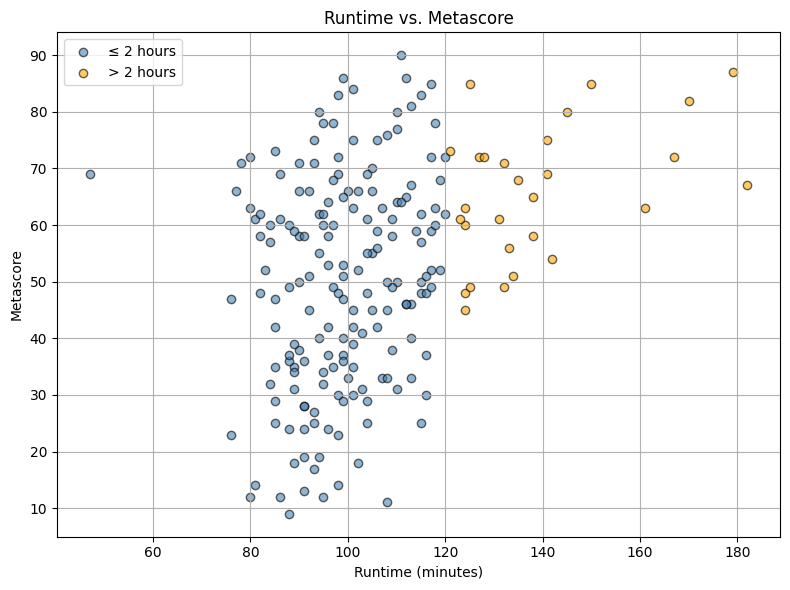

In [ ]:
# This chart again was made with the aid of ChatGPT

# Filter valid data
runtime_data = combined_data[["runtime", "score"]].dropna()

# Separate movies by runtime
long_movies = runtime_data[runtime_data["runtime"] > 120]
short_movies = runtime_data[runtime_data["runtime"] <= 120]

# Plot
plt.figure(figsize=(8, 6))

plt.scatter(short_movies["runtime"], short_movies["score"],
            color='steelblue', alpha=0.6, label="≤ 2 hours", edgecolors='k')

plt.scatter(long_movies["runtime"], long_movies["score"],
            color='orange', alpha=0.6, label="> 2 hours", edgecolors='k')

# Labels and grid
plt.title("Runtime vs. Metascore")
plt.xlabel("Runtime (minutes)")
plt.ylabel("Metascore")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Conclusions:

At first glance, I didn't really notice any strong correlation. But then I dichotomized the data from less than 2 hours of runtime and greater than 2 hours of runtime. When you look at it like this, you can clearly see that the average score for a 2+ hour movie is a lot higher than the average score of a movie less than 2 hours long. There are probably more factors than this, but I feel like longer movies perform because they are allowed more time to build tension and explore characters. Shorter movies can sometimes feel rushed, especially if they don't have sequels. Directors may not have to cut out ideas and content they want to play with as much either when the runtime is allowed to be extended. From the movies I've seen, longer movies seem to be more of a passion project by the crew making the film and I feel like that passion extends to the audience. So, I'm not saying runtime by itself creates a good movie, but maybe a long runtime is more the result of other factors that create a good movie.